In [ ]:
# Basic packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
 
# Sklearn modules & classes
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn import metrics
from scipy.stats import norm
from sklearn.utils import shuffle
from sklearn.model_selection import KFold

In [ ]:
kids_array = np.genfromtxt('kids_2022_cleaned.dat', delimiter='\t', dtype=None, encoding=None)
kids_df = pd.DataFrame(kids_array)
kids_df

,0,1,2,3,4,5,6,7,8,9,...,27,28,29,30,31,32,33,34,35,36
0,ids,dl_pp_time,du_pp_time,fl_pp_time,fu_pp_time,dl_move_time,du_move_time,fl_move_time,fu_move_time,dl_num_of_shots,...,fl_wps,fu_wps,tol_preplan_time,tol_movement_time,tol_num_of_moves,tol_excess_moves,tol_accuracy,tol_efficient_accuracy,tol_weighted_performance.score,mathScores
1,GAMAR11006,8.09,7.31,5.4,6.56,37.1,29.81,5.01,55.13,5,...,0,0,4086.17,11004.75,63,16,8,5,12,48
2,GAMAR11002,15.09,4.7,13.59,13.77,16.2,66.93,17.67,19.67,2,...,0,0,4532.67,13706.58,71,24,5,1,5,12
3,GAMAR11015,5.48,2.3,2.8,9.84,14.12,3.53,5.21,39,4,...,2,0,3868,9133.67,55,8,10,8,26,43
4,GAMAR11010,1.53,13.97,1.46,14.66,16.28,129.39,7.23,39.93,3,...,0,4,1745.33,10493.75,62,15,10,5,16,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67,MOBAU12014,5.8,18.62,23.93,14.65,18.98,49.08,20.69,31.66,4,...,0,0,3087,11982,59,12,9,6,25,NA
68,JOTON15007,5.75,19.91,3.9,10.78,23.37,26.34,19.67,83.89,5,...,3,0,2410.08,9837,56,9,10,8,26,NA
69,GARIC09019,7.82,8.42,2.65,12.33,4.53,42.65,4.28,87.17,2,...,0,0,2686.75,9439.67,64,17,10,7,24,29
70,NA,5.26,7.73,3.59,6.93,10.86,67,4.98,68.35,3,...,0,0,2122.17,10349.17,66,19,9,7,28,NA


In [ ]:
# isolate vars: du_acc, fu_acc, dl_acc, fl_acc, du_eff_acc, fu_eff_acc, tol_efficient_accuracy
kids_ea = kids_df[[19, 20, 21, 22, 23, 24, 34]]

# clean up data
kids_ea.rename(columns = {19: "du_acc", 20: "fu_acc", 21: "dl_acc", 22: "fl_acc", 23: "du_eff_acc", 24: "fu_eff_acc", 34: "tol_eff_acc"}, inplace = True)
kids_ea = kids_ea.drop([0])

# cast to int
kids_ea["du_acc"], kids_ea["fu_acc"], kids_ea["dl_acc"], kids_ea["fl_acc"], kids_ea["du_eff_acc"], kids_ea["fu_eff_acc"], kids_ea["tol_eff_acc"] = kids_ea.du_acc.astype(int), kids_ea.fu_acc.astype(int), kids_ea.dl_acc.astype(int), kids_ea.fl_acc.astype(int), kids_ea.du_eff_acc.astype(int), kids_ea.fu_eff_acc.astype(int), kids_ea.tol_eff_acc.astype(int)

# create fbe_eff_acc var
kids_ea["fbe_eff_acc"] = kids_ea.dl_acc + kids_ea.fl_acc + kids_ea.du_eff_acc + kids_ea.fu_eff_acc

# create fbe_acc var
kids_ea["fbe_acc"] = kids_ea.du_acc + kids_ea.fu_acc + kids_ea.dl_acc + kids_ea.fl_acc

kids_ea

/shared-libs/python3.9/py/lib/python3.9/site-packages/pandas/core/frame.py:4441: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


,du_acc,fu_acc,dl_acc,fl_acc,du_eff_acc,fu_eff_acc,tol_eff_acc,fbe_eff_acc,fbe_acc
1,1,1,0,0,0,0,5,0,2
2,1,0,0,0,0,0,1,0,1
3,1,1,1,1,1,0,8,3,4
4,0,1,0,0,0,1,5,1,1
5,1,1,1,0,0,1,6,2,3
...,...,...,...,...,...,...,...,...,...
67,1,1,0,0,0,0,6,0,2
68,1,0,0,1,1,0,8,2,2
69,1,0,0,0,0,0,7,0,1
70,1,0,0,0,0,0,7,0,1


In [ ]:
# X = (fbe_eff_acc, fbe_acc)
X = kids_ea[["fbe_eff_acc", "fbe_acc"]].values.tolist()

# dichotomous classification var: y = (0: low planning, 1: high planning)
y = []
mean = kids_ea["tol_eff_acc"].mean()
target = kids_ea["tol_eff_acc"]
for val in target:
    if (val <= mean):
        y.append(0)
    else:
        y.append(1)

# shuffle data
X, y = shuffle(X,y)

X = np.array(X)
y = np.array(y)

# split into training & testing datasets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)

X_train = np.array(X_train)
y_train = np.array(y_train)
X_test = np.array(X_test)
y_test = np.array(y_test)

y_train = y_train.reshape(49, 1)
y_test = y_test.reshape(22, 1)

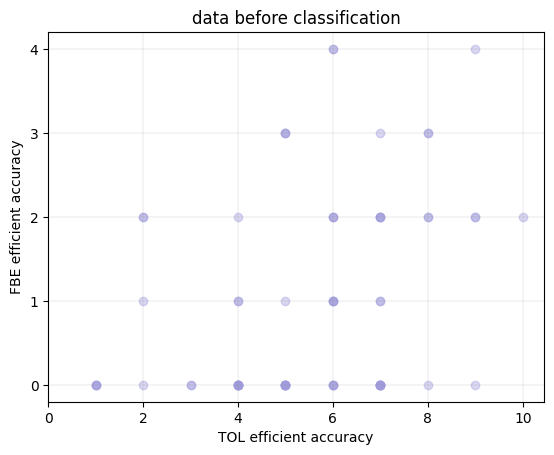

In [ ]:
# plotting tol_eff_acc and fbe_eff_acc
plt.grid(color='grey', linestyle='-', linewidth=0.25, alpha=0.5)
plt.scatter(kids_ea["tol_eff_acc"], kids_ea["fbe_eff_acc"], color="#A09CDC", alpha=.4)
plt.yticks(range(0, 5, 1))
plt.xticks(range(0, 11, 2))
plt.xlabel("TOL efficient accuracy")
plt.ylabel("FBE efficient accuracy")
plt.title("data before classification")

plt.savefig("data_before_classification.png", transparent=True)

In [ ]:
# instantiate SVC w/ linear kernel
linear_svc = SVC(kernel = 'linear', C=1)

# fit model
linear_svc.fit(X_train, y_train)

# make predictions
linear_y_pred = linear_svc.predict(X_test)

# measure performance
print("Accuracy score %.3f" %metrics.accuracy_score(y_test, linear_y_pred))

Accuracy score 0.727
/shared-libs/python3.9/py/lib/python3.9/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


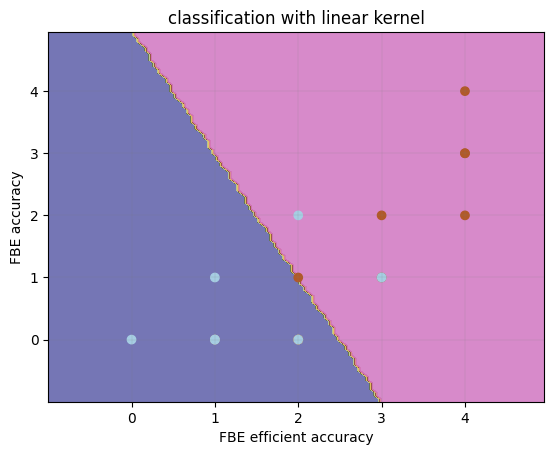

In [ ]:
# mesh plot
x_min, x_max = X_test[:, 0].min() - 1, X_test[:, 0].max() + 1
y_min, y_max = X_test[:, 1].min() - 1, X_test[:, 1].max() + 1

h = abs((y_max / y_min)/100)
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
 np.arange(y_min, y_max, h))

Z = linear_svc.predict(np.c_[yy.ravel(), xx.ravel()])

Z = Z.reshape(xx.shape)

plt.grid(color='grey', linestyle='-', linewidth=0.25, alpha=0.5)
plt.contourf(xx, yy, Z, cmap=plt.cm.get_cmap("tab20b"), alpha=0.8)
plt.scatter(X_test[:, 1], X_test[:, 0], c=y_test, cmap=plt.cm.get_cmap("Paired"))
plt.xlabel('FBE efficient accuracy')
plt.ylabel('FBE accuracy')
plt.xlim(xx.min(), xx.max())
plt.title('classification with linear kernel')
plt.yticks(range(0, 5, 1))
plt.xticks(range(0, 5, 1))

plt.savefig("linear_classification.png", transparent=True)

In [ ]:
# instantiate SVC w/ rbf kernel
rbf_svc = SVC(kernel = 'rbf', C=1)

# fit model
rbf_svc.fit(X_train, y_train)

# make predictions
rbf_y_pred = rbf_svc.predict(X_test)

# measure performance
print("Accuracy score %.3f" %metrics.accuracy_score(y_test, rbf_y_pred))

Accuracy score 0.727
/shared-libs/python3.9/py/lib/python3.9/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


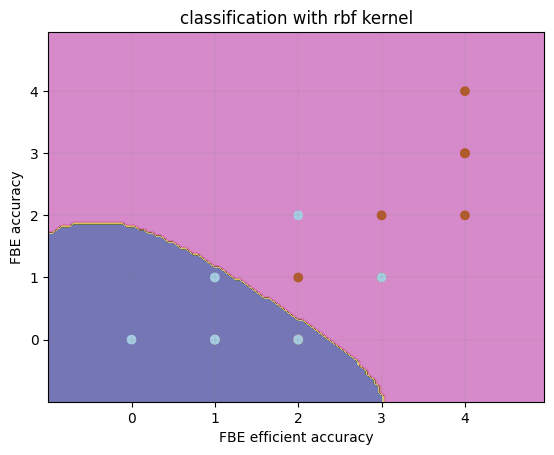

In [ ]:
# mesh plot
x_min, x_max = X_test[:, 0].min() - 1, X_test[:, 0].max() + 1
y_min, y_max = X_test[:, 1].min() - 1, X_test[:, 1].max() + 1

h = abs((y_max / y_min)/100)
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
 np.arange(y_min, y_max, h))

Z = rbf_svc.predict(np.c_[yy.ravel(), xx.ravel()])

Z = Z.reshape(xx.shape)

plt.grid(color='grey', linestyle='-', linewidth=0.25, alpha=0.5)
plt.contourf(xx, yy, Z, cmap=plt.cm.get_cmap("tab20b"), alpha=0.8)
plt.scatter(X_test[:, 1], X_test[:, 0], c=y_test, cmap=plt.cm.get_cmap("Paired"))
plt.xlabel('FBE efficient accuracy')
plt.ylabel('FBE accuracy')
plt.xlim(xx.min(), xx.max())
plt.title('classification with rbf kernel')
plt.yticks(range(0, 5, 1))
plt.xticks(range(0, 5, 1))

plt.savefig("rbf_classification.png", transparent=True)

In [ ]:
# Classification Report
from sklearn.metrics import classification_report
print(classification_report(y_test, linear_y_pred))
print(classification_report(y_test, rbf_y_pred))

              precision    recall  f1-score   support

           0       0.75      0.75      0.75        12
           1       0.70      0.70      0.70        10

    accuracy                           0.73        22
   macro avg       0.72      0.72      0.72        22
weighted avg       0.73      0.73      0.73        22

              precision    recall  f1-score   support

           0       0.75      0.75      0.75        12
           1       0.70      0.70      0.70        10

    accuracy                           0.73        22
   macro avg       0.72      0.72      0.72        22
weighted avg       0.73      0.73      0.73        22



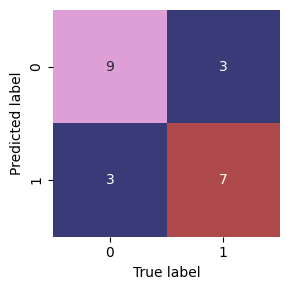

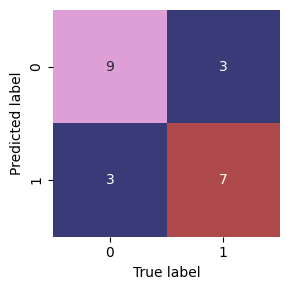

In [ ]:
# confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns

linear_conf_matrix = confusion_matrix(y_test, linear_y_pred)
fig, ax = plt.subplots(figsize=(3,3))
ax = sns.heatmap(linear_conf_matrix, annot=True, cbar=False, cmap='tab20b')

plt.xlabel("True label")
plt.ylabel("Predicted label")
plt.tight_layout()
plt.savefig("linear_conf_matrix.png", transparent=True)

rbf_conf_matrix = confusion_matrix(y_test, rbf_y_pred)
fig, ax = plt.subplots(figsize=(3,3))
ax = sns.heatmap(rbf_conf_matrix, annot=True, cbar=False, cmap='tab20b')

plt.xlabel("True label")
plt.ylabel("Predicted label")
plt.tight_layout()
plt.savefig("rbf_conf_matrix.png", transparent=True)

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=b22c459f-a4e2-4762-abe1-419ec96c9360' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>